<center>
<h4>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación</h4>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones</h3>
</center>

<h1> Práctico </h1>
<h3> Análisis y Visualización de Datos - 2020 </h3>

Durante este práctico vamos a trabajar sobre el dataset [Human Freedom Index 2018](https://www.cato.org/human-freedom-index-new) de el instituto Cato. Este índice mide en detalle lo que entendemos como libertad, utilizando 79 indicadores de libertad personal y económica en distintos aspectos, hasta obtener un hermoso numerito del 1 al 10.

Las variables más importantes sobre las que trabaja el dataset son:

* Rule of Law
* Security and Safety
* Movement
* Religion
* Association, Assembly, and Civil Society
* Expression and Information
* Identity and Relationships
* Size of Government
* Legal System and Property Rights
* Access to Sound Money
* Freedom to Trade Internationally
* Regulation of Credit, Labor, and Business

Nosotros centrarermos nuestro análisis en variables relacionadas a *Identity and Relationships* en paises de Latinoamérica, y los compararemos con las estadísticas globales. La pregunta a responder es simple: **¿Qué niveles de libertad se viven en Latinoamérica, especificamente en cuanto libertades de indentidad?**. Sin embargo, para hacer un análisis de los datos tenemos que platear también estas sub preguntas:

1. ¿Qué significa tener un puntaje de 4.5? Hay que poner los puntajes de la región en contexto con los datos del resto del mundo.
2. ¿Cuál es la tendencia a lo largo de los años? ¿Estamos mejorando, empeorando?
3. En este estudio, la libertad se mide con un estimadores principal: *hf_score* que hace referencia a Human Freedom, que a su vez está calculado en base a dos otros estimadores *ef_score*, para Economic Freedom y *pf_score*, para Personal Freedom. Estos tres estimadores, ¿se relacionan de la misma manera con la libertad de identidad?

Inicialmente, en toda exploración de datos tenemos muy poca información a priori sobre el significado de los datos y tenemos que empezar por comprenderlos. Les proponemos los siguientes ejercicios como guía para comenzar esta exploración.

In [2]:
import matplotlib.pyplot as plt
import numpy
import pandas
import seaborn
import scipy

In [3]:
seaborn.__version__

'0.10.1'

Si un archivo está disponible en la web, podemos leerlo con pandas utilizando su URL sin necesidad de descargarlo.

In [4]:
dataset = pandas.read_csv(
    'https://object.cato.org/sites/cato.org/files/human-freedom-index-files/human-freedom-index-2019.csv')
dataset.shape

(1620, 120)

In [5]:
dataset.columns  # Way too many columns!

Index(['year', 'ISO_code', 'countries', 'region', 'hf_score', 'hf_rank',
       'hf_quartile', 'pf_rol_procedural', 'pf_rol_civil', 'pf_rol_criminal',
       ...
       'ef_regulation_business_adm', 'ef_regulation_business_bureaucracy',
       'ef_regulation_business_start', 'ef_regulation_business_bribes',
       'ef_regulation_business_licensing', 'ef_regulation_business_compliance',
       'ef_regulation_business', 'ef_regulation', 'ef_score', 'ef_rank'],
      dtype='object', length=120)

Por suerte las columnas tienen un prefijo que nos ayuda a identificar a qué sección pertenecen. Nos quedamos sólo con las que comienzan con *pf_indentity*, junto con otras columnas más generales

In [6]:
score_cols = [col for col in dataset.columns if 'pf_identity' in col] + [
    'pf_score', # Personal Freedom (score)
    'pf_rank', # Personal Freedom (rank)
    'ef_score', # Economic Freedom (score)
    'ef_rank', # Economic Freedom (rank)
    'hf_score', # Human Freedom (score)
    'hf_rank', # Human Freedom (rank)
]

important_cols = ['year', 'ISO_code', 'countries', 'region'] + score_cols

In [7]:
dataset[important_cols]

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank
0,2017,ALB,Albania,Eastern Europe,0,10,10,10,7.5,5.8,8.01,46,7.67,30,7.84,38
1,2017,DZA,Algeria,Middle East & North Africa,-,0,0,0,0,0,5.2,146,4.77,159,4.99,155
2,2017,AGO,Angola,Sub-Saharan Africa,10,0,0,0,5,5,5.98,121,4.83,158,5.4,151
3,2017,ARG,Argentina,Latin America & the Caribbean,10,10,10,10,10,10,8.04,41,5.67,147,6.86,77
4,2017,ARM,Armenia,Caucasus & Central Asia,7,10,10,10,7.5,8.2,7.15,72,7.7,27,7.42,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,2008,AUS,Australia,Oceania,-,10,10,10,10,10,9.29,7,8.18,6,8.73,4
1616,2008,DNK,Denmark,Western Europe,-,10,10,10,10,10,9.49,3,7.98,9,8.73,4
1617,2008,CHE,Switzerland,Western Europe,-,10,10,10,10,10,9.31,6,8.35,4,8.83,3
1618,2008,NZL,New Zealand,Oceania,-,10,10,10,10,10,9.42,4,8.46,3,8.94,2


Si analizamos los tipos, vemos que casi todas las columnas se leen como objetos debido a que los valores nulos están marcados con `-`. Los vamos a eliminar y volveremos a convertir las columnas con puntajes a tipo numérico.

In [8]:
dataset.dtypes

year                                  int64
ISO_code                             object
countries                            object
region                               object
hf_score                             object
                                      ...  
ef_regulation_business_compliance    object
ef_regulation_business               object
ef_regulation                        object
ef_score                             object
ef_rank                              object
Length: 120, dtype: object

In [9]:
dataset = dataset[important_cols].replace('-', numpy.nan)
for score_col in score_cols:
  dataset[score_col] = pandas.to_numeric(dataset[score_col])
dataset

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank
0,2017,ALB,Albania,Eastern Europe,0.0,10.0,10.0,10.0,7.5,5.8,8.01,46.0,7.67,30.0,7.84,38.0
1,2017,DZA,Algeria,Middle East & North Africa,NaN,0.0,0.0,0.0,0.0,0.0,5.20,146.0,4.77,159.0,4.99,155.0
2,2017,AGO,Angola,Sub-Saharan Africa,10.0,0.0,0.0,0.0,5.0,5.0,5.98,121.0,4.83,158.0,5.40,151.0
3,2017,ARG,Argentina,Latin America & the Caribbean,10.0,10.0,10.0,10.0,10.0,10.0,8.04,41.0,5.67,147.0,6.86,77.0
4,2017,ARM,Armenia,Caucasus & Central Asia,7.0,10.0,10.0,10.0,7.5,8.2,7.15,72.0,7.70,27.0,7.42,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,2008,AUS,Australia,Oceania,NaN,10.0,10.0,10.0,10.0,10.0,9.29,7.0,8.18,6.0,8.73,4.0
1616,2008,DNK,Denmark,Western Europe,NaN,10.0,10.0,10.0,10.0,10.0,9.49,3.0,7.98,9.0,8.73,4.0
1617,2008,CHE,Switzerland,Western Europe,NaN,10.0,10.0,10.0,10.0,10.0,9.31,6.0,8.35,4.0,8.83,3.0
1618,2008,NZL,New Zealand,Oceania,NaN,10.0,10.0,10.0,10.0,10.0,9.42,4.0,8.46,3.0,8.94,2.0


# Parte 1

Luego de las clases del primer fin de semana, ya tenemos las herramientas para responder las siguientes preguntas:

## 1. Estadísticos descriptivos

  1. Para comenzar con un pantallazo de los datos, calcular el rango de las variables.
  3. Para cada país, tenemos varias realizaciones para cada variable *pf_identity* y *hf_score*. Si queremos comparar un país con otro, ¿cuál es la manera adecuada de hacerlo? Por ejemplo, ¿nos quedamos con un único valor? ¿o comparamos todos los valores? ¿usamos el promedio? ¿usamos la mediana? 
  2. Obtener media, mediana y desviación estándar de las variables *pf_identity* y *hf_score* en el mundo y compararla con la de Latinoamérica y el caribe. Usar la respuesta del punto anterior para justificar si la comparación es válida o no.
  3. ¿Tiene sentido calcular la moda?
  4. ¿Cómo pueden sanearse los valores faltantes?
  5. ¿Encuentra outliers en estas dos variables? ¿Qué método utiliza para detectarlos? Los outliers, ¿son globales o por grupo? ¿Los eliminaría del conjunto de datos?
  

In [10]:
seaborn.set(font_scale=1.5)  # Para cambiar tamaño de labels en los gráficos

#### 1.1. Rango de las variables
Para las variables numéricas que son indicadores (excluimos el año), tomamos el valor máximo y el valor mínimo para cada una de ellas y luego calculamos la diferencia, que nos da el rango de cada variable.

In [11]:
print("Los rangos de las variables analizadas son:")
for score_col in score_cols:
    df_score_col = dataset[score_col]
    var_min = df_score_col.min()
    var_max = df_score_col.max()
    var_range = (var_max - var_min).round(4)
    print(f"'{score_col}': rango: {var_range}, mínimo: {var_min}, máximo: {var_max}")

Los rangos de las variables analizadas son:
'pf_identity_legal': rango: 10.0, mínimo: 0.0, máximo: 10.0
'pf_identity_sex_male': rango: 10.0, mínimo: 0.0, máximo: 10.0
'pf_identity_sex_female': rango: 10.0, mínimo: 0.0, máximo: 10.0
'pf_identity_sex': rango: 10.0, mínimo: 0.0, máximo: 10.0
'pf_identity_divorce': rango: 10.0, mínimo: 0.0, máximo: 10.0
'pf_identity': rango: 10.0, mínimo: 0.0, máximo: 10.0
'pf_score': rango: 7.34, mínimo: 2.22, máximo: 9.56
'pf_rank': rango: 161.0, mínimo: 1.0, máximo: 162.0
'ef_score': rango: 6.53, mínimo: 2.58, máximo: 9.11
'ef_rank': rango: 161.0, mínimo: 1.0, máximo: 162.0
'hf_score': rango: 5.43, mínimo: 3.69, máximo: 9.12
'hf_rank': rango: 161.0, mínimo: 1.0, máximo: 162.0


#### 1.2. Formas de comparar un país con otro

Si bien consideramos varias maneras de comparar países (calcular un estimador que pondere la media de cada país en toda la serie y la tendencia, tomar el valor puntual de cada variable en el último año para cada país, entre otros) creemos que la que mejor forma de comparar fue tomar la media por país y considerar la varianza de cada variable. Observar la varianza nos aporta una idea de cuán estable es la media que estamos observando. Para ejemplificar, observemos los barplots que se muestran a continuación: en ellos podemos ver la comparación entre Venezuela y Argentina. Si nos centramos en la variable 'pf_identity' podemos ver que la media no difiere tanto. Sin embargo, la varianza es significativamente distinta en cada país: en Argentina no hay varianza y en Venezuela es grande. Esto implica que Argentina es un país muy estable en cuanto a libertad personal y Venezuela no tanto. Sin embargo al tomar solo estos gráficos, perdemos de vista la variable temporal que es en dónde podemos encontrar alguna respuesta a la varianza observada. Es por eso que incluímos tambien un lineplot por año de cada variable. En este ejemplo en particular, vemos que Venezuela tuvo una fuerte caída de la libertad personal a partir del año 2014 pero entre los años 2008 y 2014 puntuó muy bien; eso explica que la media y la varianza hayan dado altas. Además, al revisar ese cambio abrupto a partir del 2014 podríamos dar una explicación de lo sucedido en el país en particular.
En conclusión: si bien la media con la varianza ya es una buena forma de comparar países, observando los lineplots podemos profundizar el análisis. Sin embargo, los lineplots solos no sirven porque no siempre es tan evidente cuál es "mejor" (observar, por ejemplo, el lineplot de hf_score para Brasil y Bolivia

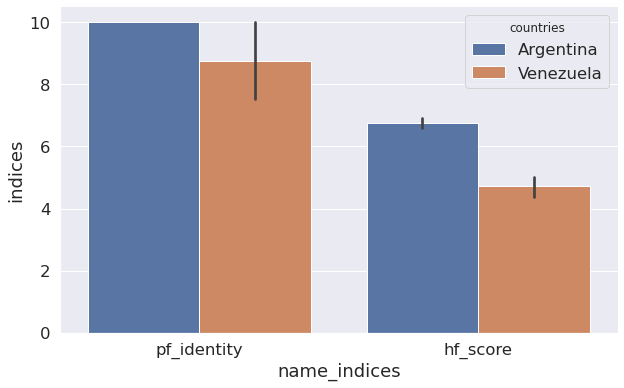

In [12]:
df_mean_melt = pandas.melt(dataset, id_vars=['countries','year'], value_vars = ['pf_identity', 'hf_score'], var_name='name_indices', value_name='indices')

pais_1 = 'Argentina'
pais_2 = 'Venezuela'

df_to_plot = df_mean_melt[(df_mean_melt.countries == pais_1) | (df_mean_melt.countries == pais_2)]

plt.figure(figsize=(10,6))
seaborn.barplot(data = df_to_plot, x = 'name_indices', y = 'indices', hue = 'countries' )
seaborn.despine()

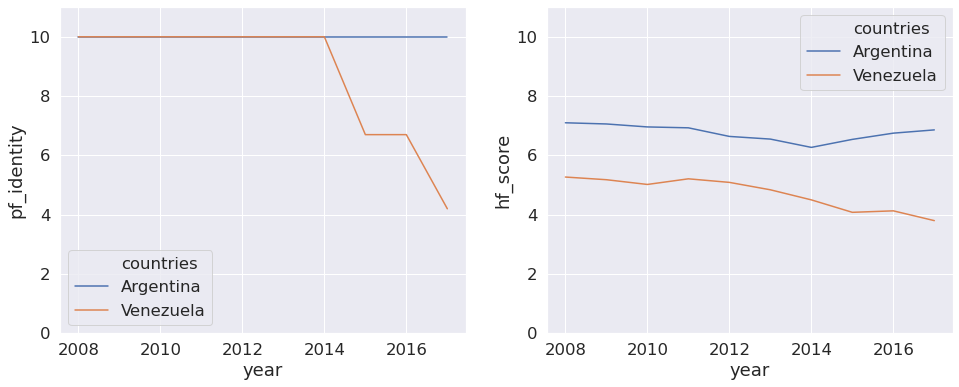

In [13]:
countries = ['Argentina', 'Venezuela']
sel_countries_filter = dataset['countries'].isin(countries)
df_sel_countries = dataset[sel_countries_filter]

fig, axs = plt.subplots(ncols=2, figsize=(16, 6))  # para plotear un gráfico al lado del otro
seaborn.lineplot(data=df_sel_countries, x='year', y='pf_identity', hue='countries', ax=axs[0])
seaborn.lineplot(data=df_sel_countries, x='year', y='hf_score', hue='countries', ax=axs[1])
for ax in axs:
    ax.set_ylim(0, 11)  # eje y no puede ser menor a 0 ni mayor a 10

#### 1.3 Cálculo de media, mediana y desviación estándar de las variables *pf_identity* y *hf_score* en el mundo. Comparación con la de Latinoamérica y el caribe
Realizamos el cálculo de las medidas estadísticas a continuación. A partir de ellos, concluimos que no tiene mucho sentido tomar una medida como la media, dado que al hacerlo de esa forma se pierde información sobre, por ejemplo, cómo viene evolucionando el indicador en el tiempo, además que valores extremos pueden estar distorsionando la media.

In [14]:
selected_scores = ['pf_identity', 'hf_score']
la_filter = dataset['region'] == 'Latin America & the Caribbean'
dataset_la = dataset[la_filter]

for score in selected_scores:
    df_score_world = dataset[score]
    df_score_la = dataset_la[score]
    # Mean
    mean_world = df_score_world.mean()
    mean_la = df_score_la.mean()
    # Median
    median_world = df_score_world.median()
    median_la = df_score_la.median()
    # Standard deviation
    std_world = df_score_world.std()
    std_la = df_score_la.std()
    
    print(f"Respecto a la variable '{score}', los valores del mundo respecto a LA son:")
    print(f"Media del mundo: {mean_world.round(3)}; Media de LA: {mean_la.round(3)}")
    print(f"Mediana del mundo: {median_world.round(3)}; Mediana de LA: {median_la.round(3)}")
    print(f"Desviación estándar del mundo: {std_world.round(3)}; Desviación estándar de LA: {std_la.round(3)}\n")

Respecto a la variable 'pf_identity', los valores del mundo respecto a LA son:
Media del mundo: 7.281; Media de LA: 8.582
Mediana del mundo: 8.8; Mediana de LA: 10.0
Desviación estándar del mundo: 3.182; Desviación estándar de LA: 1.876

Respecto a la variable 'hf_score', los valores del mundo respecto a LA son:
Media del mundo: 6.978; Media de LA: 7.037
Mediana del mundo: 6.9; Mediana de LA: 7.02
Desviación estándar del mundo: 1.056; Desviación estándar de LA: 0.635



#### 1.4 Cálculo de moda: ¿tiene sentido?
No tendría sentido tomar la moda debido a que tenemos pocos valores por cada país (máximo 10) y es probable que no haya moda dado que los indicadores son variables de tipo continuas, por lo que cada año puede haber valores distintos.

In [15]:
for score in selected_scores:
    df_score_world = dataset[score]
    df_score_la = dataset_la[score]
    # Mode
    mode_world = df_score_world.mode()
    mode_la = df_score_la.mode()
    
    print(f"Respecto a la variable '{score}', los valores del mundo respecto a LA son:")
    print(f"Moda del mundo: {mode_world}; Media de LA: {mode_la}\n")


Respecto a la variable 'pf_identity', los valores del mundo respecto a LA son:
Moda del mundo: 0    10.0
dtype: float64; Media de LA: 0    10.0
dtype: float64

Respecto a la variable 'hf_score', los valores del mundo respecto a LA son:
Moda del mundo: 0    6.75
dtype: float64; Media de LA: 0    6.72
dtype: float64



#### 1.5 ¿Cómo sanear los valores faltantes?
Hay diferentes formas que uno podría pensar para sanear los valores faltantes:
1. ##### Sustitución por la Media: 
Consiste en sustituir el valor ausente por la Media de los valores válidos. Este procedimiento plantea inconvenientes como:
- Dificulta la estimación de la Variancia.
- Distorsiona la verdadera distribución de la variable,
- Distorsiona la correlación entre variables dado que añade valores constantes.
2. ##### Sustitución por constante: 
Consiste en sustituir los valores ausentes por constantes cuyo valor viene determinado por razones teóricas o relacionadas con la investigación previa. Presenta los mismos inconvenientes que la sustitución por la Media, y solo debe ser utilizado si hay razones para suponer que es más adecuado que el método de la media.
3. ##### Imputación por regresión: 
Este método consiste en estimar los valores ausentes en base a su relación con otros variables mediante Análisis de Regresión. Inconvenientes:
- Incrementa artificialmente las relaciones entre variables.
- Hace que se subestime la Variáncia de las distribuciones.
- Asume que las variables con datos ausentes tienen relación de alta magnitud con las otras variables.

Dado este conjunto de datos en particular, una buena opción es rellenar estos datos faltantes con la media del propio país, o con la media de la región, o con la media de algún país que se lo considere similar en el aspecto en cuestión.
Si se trata de una serie de tiempo, es posible considerar la interpolación del valor faltante mediante el ajuste de una curva a los datos que tengamos disponibles.

In [16]:
print("Cantidad de valores faltantes por columna:\n")
dataset.isna().sum()

Cantidad de valores faltantes por columna:



year                         0
ISO_code                     0
countries                    0
region                       0
pf_identity_legal         1312
pf_identity_sex_male        83
pf_identity_sex_female      80
pf_identity_sex             80
pf_identity_divorce        101
pf_identity                 80
pf_score                    80
pf_rank                     80
ef_score                    80
ef_rank                     80
hf_score                    80
hf_rank                     80
dtype: int64

In [17]:
def calculate_measure_by_column(df, col, agg='mean'):
    """
    Performs aggregation over col and fills NaN values of df with the result.
    """
    
    # Calculate measure by column
    df_by_col_and_year = df.copy()
    df_by_col_and_year = df_by_col_and_year.set_index([col, 'year'])[score_cols]
    df_measure_by_col = df_by_col_and_year.groupby([col]).agg(agg).reset_index()
    renamed_columns_dict = {col: col + '_measure' for col in score_cols}
    df_measure_by_col = df_measure_by_col.rename(columns=renamed_columns_dict)  # rename columns so that they are different than the ones in the original dataframe
    # Join measure to dataframe
    df_new = df.merge(df_measure_by_col, on=col, how='left')
    for score in score_cols:
        df_new[score] = numpy.where(df_new[score].isna(), df_new[score + '_measure'], df_new[score])
    df_new = df_new.drop(columns=renamed_columns_dict.values())
    return df_new

In [18]:
df_clean = calculate_measure_by_column(dataset, 'countries', agg='mean')

print("Cantidad de valores faltantes por columna luego de limpieza por país:\n")
df_clean.isnull().sum()

Cantidad de valores faltantes por columna luego de limpieza por país:



year                        0
ISO_code                    0
countries                   0
region                      0
pf_identity_legal         590
pf_identity_sex_male        0
pf_identity_sex_female      0
pf_identity_sex             0
pf_identity_divorce         0
pf_identity                 0
pf_score                    0
pf_rank                     0
ef_score                    0
ef_rank                     0
hf_score                    0
hf_rank                     0
dtype: int64

Como aún quedan valores vacíos, calculamos la media por región y se completamos los NaN restantes

In [19]:
df_clean = calculate_measure_by_column(df_clean, 'region', agg='mean')

print("Cantidad de valores faltantes por columna luego de limpieza por país y región:\n")
df_clean.isnull().sum()

Cantidad de valores faltantes por columna luego de limpieza por país y región:



year                      0
ISO_code                  0
countries                 0
region                    0
pf_identity_legal         0
pf_identity_sex_male      0
pf_identity_sex_female    0
pf_identity_sex           0
pf_identity_divorce       0
pf_identity               0
pf_score                  0
pf_rank                   0
ef_score                  0
ef_rank                   0
hf_score                  0
hf_rank                   0
dtype: int64


<font color='red'>**TODO: CALCULAR MEDIA DE ÚLTIMOS AÑOS Y RELLENAR CON ESO**<font>

#### 1.6. Outliers
Formas de detectarlos:
1. Gráficamente: realizando un boxplot por región, es posible distinguir, para cada región, algunas observaciones que se ubican fuera del intervalo de confianza definido en el boxplot (los puntos fuera del rango de los "bigotes"). También podría buscarse outliers dentro de una región por país.
2. Normalizando los valores por región, calculando la media y eligiendo una cantidad determinada de desviaciones estándar desde la media a partir de la cual consideramos que esos países son outliers.

##### 1.6.1. Detección de outliers de manera gráfica

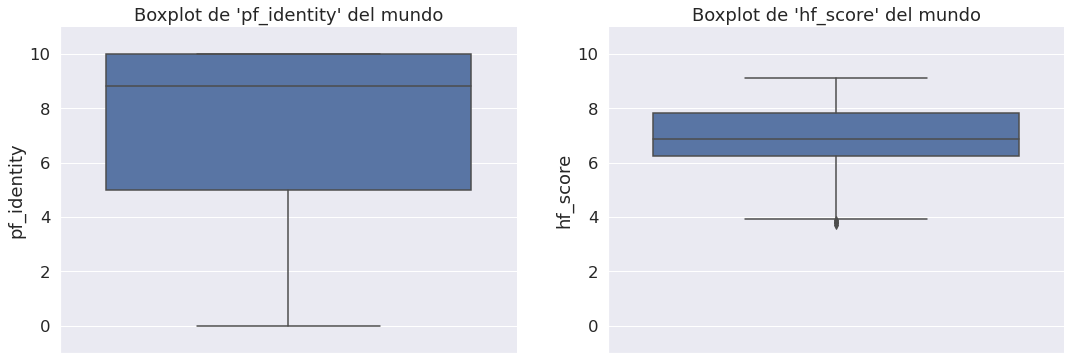

In [20]:
fig, axs = plt.subplots(ncols=2, figsize=(18, 6))  # para plotear un gráfico al lado del otro
seaborn.boxplot(y=df_clean['pf_identity'], ax=axs[0])
seaborn.boxplot(y=df_clean['hf_score'], ax=axs[1])
for ax in axs:
    ax.set_ylim(-1, 11)  # eje y no puede ser menor a 0 ni mayor a 10
    ax.tick_params(axis='x', labelrotation=90, labelsize=12)

axs[0].title.set_text("Boxplot de 'pf_identity' del mundo")
axs[1].title.set_text("Boxplot de 'hf_score' del mundo")
seaborn.despine()

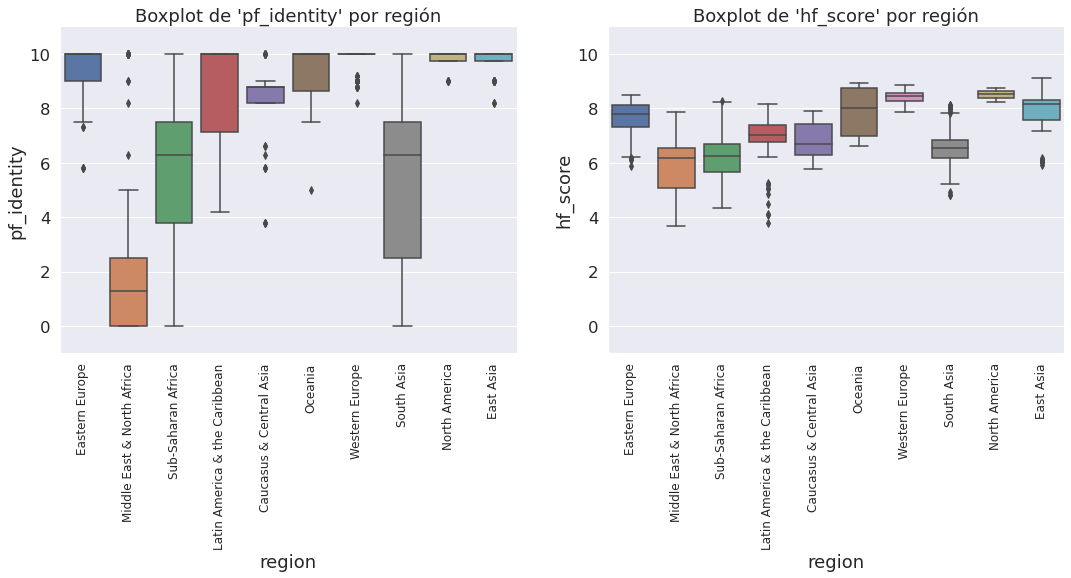

In [21]:
fig, axs = plt.subplots(ncols=2, figsize=(18, 6))  # para plotear un gráfico al lado del otro
seaborn.boxplot(x=df_clean['region'], y=df_clean['pf_identity'], ax=axs[0])
seaborn.boxplot(x=df_clean['region'], y=df_clean['hf_score'], ax=axs[1])
for ax in axs:
    ax.set_ylim(-1, 11)  # eje y no puede ser menor a 0 ni mayor a 10
    ax.tick_params(axis='x', labelrotation=90, labelsize=12)

axs[0].title.set_text("Boxplot de 'pf_identity' por región")
axs[1].title.set_text("Boxplot de 'hf_score' por región")
seaborn.despine()

##### 1.6.2. Detección de outliers a partir de su probabilidad de ocurrencia

In [22]:
print('Cantidad de países por región')
dataset[dataset['year'] == 2017].groupby(['region']).count()['countries']

Cantidad de países por región


region
Caucasus & Central Asia           6
East Asia                         6
Eastern Europe                   22
Latin America & the Caribbean    26
Middle East & North Africa       19
North America                     2
Oceania                           4
South Asia                       17
Sub-Saharan Africa               42
Western Europe                   18
Name: countries, dtype: int64

In [23]:
def find_outliers(data, selected_score, number_of_stds):
    dfs_outliers = []
    for region in data['region'].unique():
        for year in data['year'].unique():
            dataset_reg = data[(data['region'] == region) & (data['year'] == year)]
            score = dataset_reg[selected_score]
            score_mean = score.mean()
            score_median = score.median()
            abs_diff = numpy.abs(score - score_mean)
            score_std = score.std()
            outlier_mask = abs_diff > (score_std * number_of_stds)
            df_region_outliers = dataset_reg[outlier_mask][['year', 'countries', 'region', selected_score]]
            df_region_outliers[selected_score + '_mean'] = score_mean.round(3)
            df_region_outliers[selected_score + '_median'] = score_median.round(3)
            df_region_outliers[selected_score + '_std'] = score_std.round(3)
            df_region_outliers = df_region_outliers.sort_values(by=['countries', 'year'])
            dfs_outliers.append(df_region_outliers)

    df_outliers = pandas.concat(dfs_outliers)

    return df_outliers

##### 1.6.2.a. Detección de outliers para 'pf_identity'

In [24]:
df_outliers_pf_identity = find_outliers(dataset, 'pf_identity', number_of_stds=2.5)

df_outliers_pf_identity

,year,countries,region,pf_identity,pf_identity_mean,pf_identity_median,pf_identity_std
0,2017,Albania,Eastern Europe,5.8,8.836,9.0,0.906
162,2016,Albania,Eastern Europe,5.8,9.014,9.0,0.970
324,2015,Albania,Eastern Europe,5.8,9.052,9.0,0.977
543,2014,Greece,Eastern Europe,7.5,9.824,10.0,0.593
687,2013,Cyprus,Eastern Europe,7.5,9.705,10.0,0.778
705,2013,Greece,Eastern Europe,7.5,9.705,10.0,0.778
849,2012,Cyprus,Eastern Europe,7.5,9.705,10.0,0.778
867,2012,Greece,Eastern Europe,7.5,9.705,10.0,0.778
1011,2011,Cyprus,Eastern Europe,7.5,9.705,10.0,0.778
1029,2011,Greece,Eastern Europe,7.5,9.705,10.0,0.778


##### 1.6.2.a. Detección de outliers para 'hf_score'

In [25]:
df_outliers_hf_score = find_outliers(dataset, 'hf_score', number_of_stds=2.5)

df_outliers_hf_score

,year,countries,region,hf_score,hf_score_mean,hf_score_median,hf_score_std
476,2015,Ukraine,Eastern Europe,5.88,7.646,7.820,0.706
1096,2011,Russia,Eastern Europe,6.43,7.736,7.880,0.517
1420,2009,Russia,Eastern Europe,6.41,7.731,7.870,0.517
137,2017,Sudan,Sub-Saharan Africa,4.32,6.231,6.315,0.671
299,2016,Sudan,Sub-Saharan Africa,4.44,6.243,6.360,0.714
744,2013,Mauritius,Sub-Saharan Africa,8.13,6.286,6.345,0.702
906,2012,Mauritius,Sub-Saharan Africa,8.29,6.185,6.170,0.739
1068,2011,Mauritius,Sub-Saharan Africa,8.25,6.232,6.130,0.730
1230,2010,Mauritius,Sub-Saharan Africa,8.19,6.263,6.270,0.687
1392,2009,Mauritius,Sub-Saharan Africa,8.10,6.235,6.160,0.670


##### Dataset sin outliers

In [26]:
dataset_wo_outliers = dataset[~dataset.index.isin(df_outliers_pf_identity.index)]
dataset_wo_outliers = dataset_wo_outliers[~dataset_wo_outliers.index.isin(df_outliers_hf_score.index)]

dataset_wo_outliers

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank
1,2017,DZA,Algeria,Middle East & North Africa,NaN,0.0,0.0,0.0,0.0,0.0,5.20,146.0,4.77,159.0,4.99,155.0
2,2017,AGO,Angola,Sub-Saharan Africa,10.0,0.0,0.0,0.0,5.0,5.0,5.98,121.0,4.83,158.0,5.40,151.0
3,2017,ARG,Argentina,Latin America & the Caribbean,10.0,10.0,10.0,10.0,10.0,10.0,8.04,41.0,5.67,147.0,6.86,77.0
4,2017,ARM,Armenia,Caucasus & Central Asia,7.0,10.0,10.0,10.0,7.5,8.2,7.15,72.0,7.70,27.0,7.42,54.0
5,2017,AUS,Australia,Oceania,7.0,10.0,10.0,10.0,10.0,9.0,9.16,12.0,8.07,9.0,8.62,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,2008,AUS,Australia,Oceania,NaN,10.0,10.0,10.0,10.0,10.0,9.29,7.0,8.18,6.0,8.73,4.0
1616,2008,DNK,Denmark,Western Europe,NaN,10.0,10.0,10.0,10.0,10.0,9.49,3.0,7.98,9.0,8.73,4.0
1617,2008,CHE,Switzerland,Western Europe,NaN,10.0,10.0,10.0,10.0,10.0,9.31,6.0,8.35,4.0,8.83,3.0
1618,2008,NZL,New Zealand,Oceania,NaN,10.0,10.0,10.0,10.0,10.0,9.42,4.0,8.46,3.0,8.94,2.0


Para detectar observaciones outliers, lo que hicimos fue verificar, para cada región y año, qué países se apartaban de la media en más de 2.5 desviaciones estándar.<br>
Los valores observados de estos países en dichos años no parecen ser producto de errores de carga o de estimación (esperaríamos valores absurdos para pensar de que se trata de un error). A su vez, en esta lista podemos ver a Venezuela y Rusia como países cuya Human Freedom se caracteriza por estar significativamente por debajo de la media de su región, lo cual no parece ser sorpresivo conociendo los hechos que sucedieron en estos países.<br>
Por otra parte, no existen países que sean outliers tanto para 'pf_identity' como para 'hf_score', por lo que eliminar un punto o un país del dataset porque es outlier en sólo uno de los dos scores analizados puede ser cuestionable.<br>
Por estas razones, para el cálculo y análisis de algunas métricas, compararemos el dataset con los outliers detectados y también el dataset sin éstos.

## 2. Agregación de datos

1. Grafiquen la media de la variable *pf_identity* y *hf_score* a través de los años.
2. Realicen los mismos gráficos, pero separando por regiones (Cada variable en un gráfico distinto, sino no se ve nada). ¿La tendencia observada, es la misma que si no dividimos por regiones?
3. Si lo consideran necesario, grafiquen algunos países de Latinoamerica para tratar de explicar la tendencia de la variable *pf_identity* en la región. ¿Cómo seleccionarion los países relevantes a esa tendencia?

Pista: hay gráficos de seaborn que permiten generar visualizaciones para cada valor de una variable categórica, en este caso, las distintas regiones.

Sólo por curiosidad, graficar la tendencia de *hf_score* y *ef_score* a través de los años. ¿Tienen alguna hipótesis para este comportamiento?

2.1

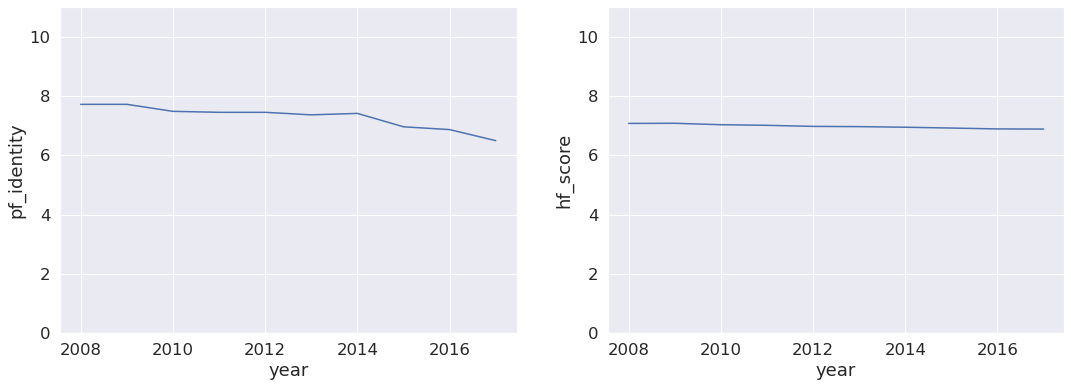

In [27]:
# MUNDO
# SOLO POR CURIOSIDAD, TENDENCIA DE HUMAN FREEDOM SCORE Y ECONOMIC FREEDOM SCORE

df_mean_year = dataset.groupby(['year']).mean()[['pf_identity', 'hf_score']].reset_index()

fig, axs = plt.subplots(ncols=2, figsize=(18, 6))  # para plotear un gráfico al lado del otro
seaborn.lineplot(data=df_mean_year, x='year', y='pf_identity', ax=axs[0], legend=False)
seaborn.lineplot(data=df_mean_year, x='year', y='hf_score', ax=axs[1])
for ax in axs:
    ax.set_ylim(0, 11)  # eje y no puede ser menor a 0 ni mayor a 10

plt.show()

Analizando la línea de tiempo de la variable 'pf_identity', es posible notar que existe una tendencia a nivel mundial a decrecer en estos valores desde el año 2014.

2.2

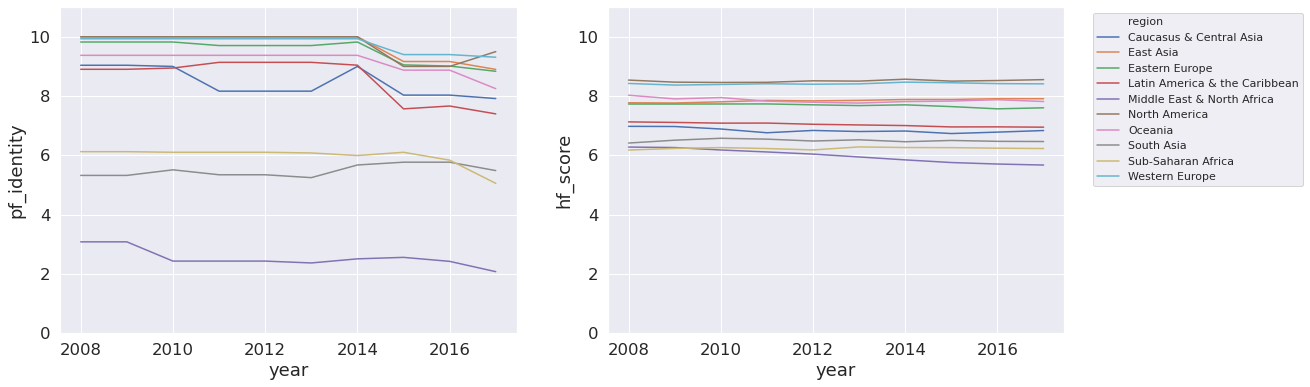

In [28]:
# REGIONES
df_mean_by_year_region = dataset.groupby(['region', 'year']).mean()[['pf_identity', 'hf_score']].reset_index()

# GRAFICO
fig, axs = plt.subplots(ncols=2, figsize=(18, 6))  # para plotear un gráfico al lado del otro
seaborn.lineplot(x='year', y='pf_identity', hue='region', data=df_mean_by_year_region, ax=axs[0], legend=False)
seaborn.lineplot(x='year', y='hf_score', hue='region', data=df_mean_by_year_region, ax=axs[1])
for ax in axs:
    ax.set_ylim(0, 11)  # eje y no puede ser menor a 0 ni mayor a 10
plt.legend(bbox_to_anchor=(1.05, 1), prop={'size': 11})  # para mover la leyenda a la derecha

plt.show()

2.3

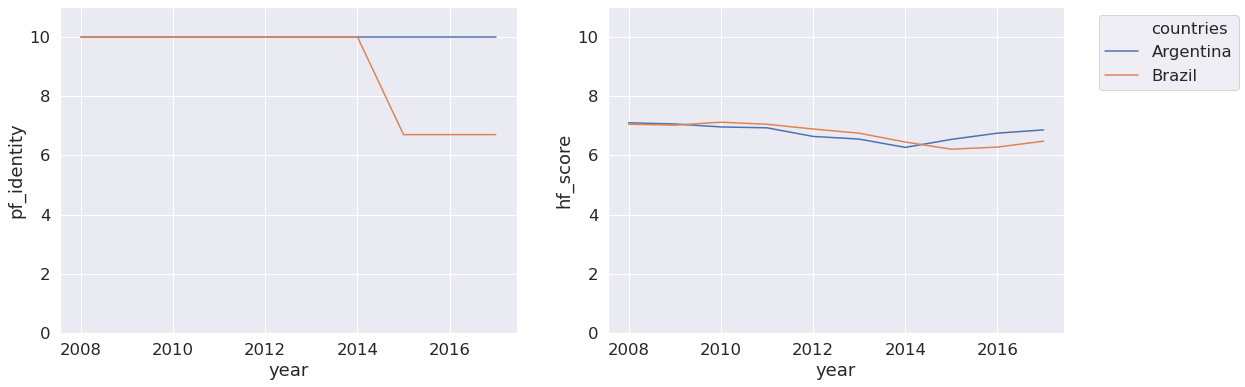

In [29]:
# PAISES RELEVANTES DE LATINOAMERICA, CONSIDERADOS POR SU MAYOR POBLACIÓN
selected_countries_2 = ['Argentina', 'Brazil']
df_selected_countries_2 = dataset[dataset['countries'].isin(selected_countries_2)]
df_mean_by_year_selected_countries_2 = df_selected_countries_2.groupby(['countries', 'year']).mean()[['pf_identity', 'hf_score']].reset_index()

## GRAFICO
fig, axs = plt.subplots(ncols=2, figsize=(18, 6))  # para plotear un gráfico al lado del otro
seaborn.lineplot(x='year', y='pf_identity', hue='countries', data=df_mean_by_year_selected_countries_2, ax=axs[0], legend=False)
seaborn.lineplot(x='year', y='hf_score', hue='countries', data=df_mean_by_year_selected_countries_2, ax=axs[1])
for ax in axs:
    ax.set_ylim(0, 11)  # eje y no puede ser menor a 0 ni mayor a 10
plt.legend(bbox_to_anchor=(1.4, 1))  # para mover la leyenda a la derecha

plt.show()

Podemos ver en la línea de tiempo de la variable 'pf_identity' de Brasil la gran decaída que sufre dicha variable en el año 2014. La misma decaída puede observarse en la línea de tiempo de la variable para toda Latinoamérica y el Caribe, por lo que se puede decir que Brasil es un país relevante de la región, ya que los cambios que ocurren ahí repercuten en toda Latinoamérica.

2.4 Por curiosidad

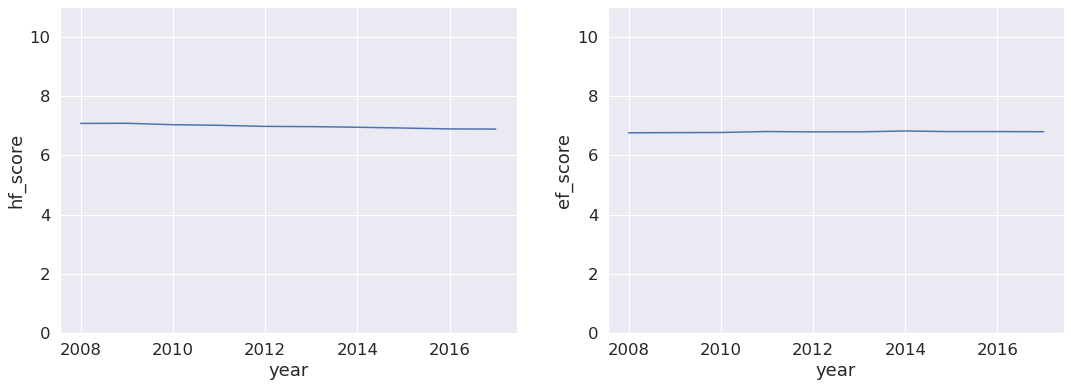

In [30]:
# MUNDO
# SOLO POR CURIOSIDAD, TENDENCIA DE HUMAN FREEDOM SCORE Y ECONOMIC FREEDOM SCORE

df_mean_year = dataset.groupby(['year']).mean()[['hf_score', 'ef_score']].reset_index()

fig, axs = plt.subplots(ncols=2, figsize=(18, 6))  # para plotear un gráfico al lado del otro
seaborn.lineplot(data=df_mean_year, x='year', y='hf_score', ax=axs[0], legend=False)
seaborn.lineplot(data=df_mean_year, x='year', y='ef_score', ax=axs[1])
for ax in axs:
    ax.set_ylim(0, 11)  # eje y no puede ser menor a 0 ni mayor a 10

plt.show()

## 3. Distribuciones
  1. Graficar en un mismo histograma la distribución de la variable *pf_identity* en global, y en Latinoamérica y el caribe. Repetir para la variable *hf_score*. ¿Visualmente, a qué tipo de distribución corresponde cada variable? ¿Es correcto utilizar todos el conjunto de valores disponibles para esa region en estos gráficos?


In [31]:
# Selección de países de América Latina
la_countries_filter =['Argentina', 'Mexico', 'Colombia', 'Argentina', 'Peru', 'Venezuela', 'Chile']  # Elección por cantidad de habitantes. Representan el 80% de la población de América Latina, aproximadamente.
df_la_filtered = dataset_la[dataset_la['countries'].isin(la_countries_filter)]
df_la_filtered_last_year = df_la_filtered[df_la_filtered['year'] == 2017]
df_world_last_year = dataset[dataset['year'] == 2017]

#### 3.a. Distribución de 'pf_identity' en el mundo y Latinoamérica y caribe
Visualmente, la variable 'pf_identity parace tener una distribución con asimetría negativa (o hacia la izquierda). En el caso de latinoamérica, al tomar sólo algunos países (7 de los que más cantidad de habitantes tienen) y ver el último año, la distribución se acerca a una uniforme.

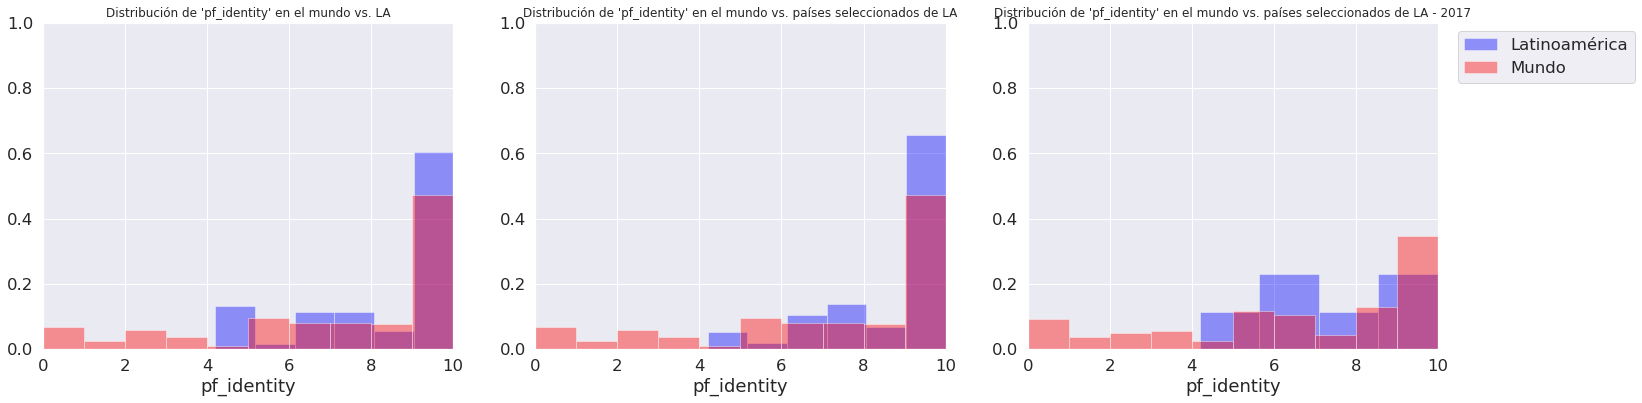

In [32]:
fig, axs = plt.subplots(ncols=3, figsize=(25, 6))  # para plotear un gráfico al lado del otro

# Histogramas de mundo y LA (plot 1), histogramas de mundo y países seleccionados de LA (plot 2), histogramas de mundo y países seleccionados de LA para 2017 (plot 3)
seaborn.distplot(dataset_la['pf_identity'], kde=False, bins=6, label='Latinoamérica', color='blue', norm_hist=True, ax=axs[0])
seaborn.distplot(dataset['pf_identity'], kde=False, bins=10, label='Mundo', color='red', norm_hist=True, ax=axs[0])
seaborn.distplot(df_la_filtered['pf_identity'], kde=False, bins=6, label='Latinoamérica', color='blue', norm_hist=True, ax=axs[1])
seaborn.distplot(dataset['pf_identity'], kde=False, bins=10, label='Mundo', color='red', norm_hist=True, ax=axs[1])
seaborn.distplot(df_la_filtered_last_year['pf_identity'], kde=False, bins=4, label='Latinoamérica', color='blue', norm_hist=True, ax=axs[2])
seaborn.distplot(df_world_last_year['pf_identity'], kde=False, bins=10, label='Mundo', color='red', norm_hist=True, ax=axs[2])

for ax in axs:
    ax.set_xlim(0, 10)  # eje x no puede ser menor a 0 ni mayor a 10
    ax.set_ylim(0, 1)  # eje y no puede ser menor a 0 ni mayor a 1
    ax.title.set_fontsize(12)
axs[0].title.set_text("Distribución de 'pf_identity' en el mundo vs. LA")
axs[1].title.set_text("Distribución de 'pf_identity' en el mundo vs. países seleccionados de LA")
axs[2].title.set_text("Distribución de 'pf_identity' en el mundo vs. países seleccionados de LA - 2017")
plt.legend(bbox_to_anchor=(1.5, 1))  # para mover la leyenda a la derecha

plt.show()

#### 3.b. Distribución de 'hf_score' en el mundo y Latinoamérica y caribe
Visualmente, la variable 'hfscore' parace tener distribución cercana a la Normal.

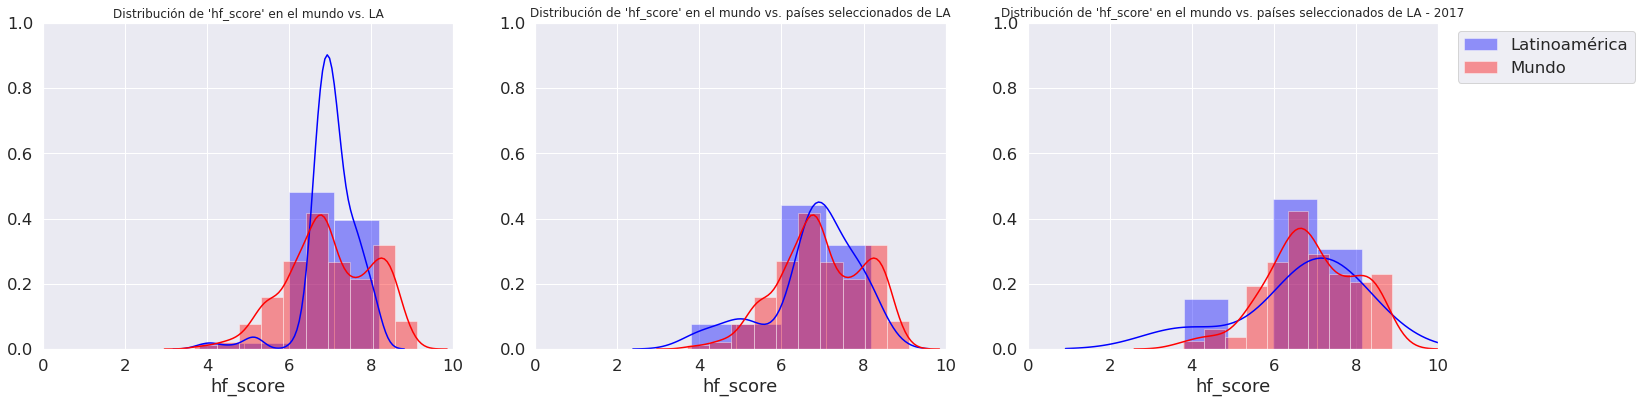

In [33]:
fig, axs = plt.subplots(ncols=3, figsize=(25, 6))  # para plotear un gráfico al lado del otro

# Histogramas de mundo y LA (plot 1), histogramas de mundo y países seleccionados de LA (plot 2), histogramas de mundo y países seleccionados de LA para 2017 (plot 3)
# Podemos plotear la función de densidad (kde=True) porque nunca se extiende fuera de 0, 10.
seaborn.distplot(dataset_la['hf_score'], kde=True, bins=4, label='Latinoamérica', color='blue', ax=axs[0])
seaborn.distplot(dataset['hf_score'], kde=True, bins=10, label='Mundo', color='red', ax=axs[0])
seaborn.distplot(df_la_filtered['hf_score'], kde=True, bins=4, label='Latinoamérica', color='blue', ax=axs[1])
seaborn.distplot(dataset['hf_score'], kde=True, bins=10, label='Mundo', color='red', ax=axs[1])
seaborn.distplot(df_la_filtered_last_year['hf_score'], kde=True, bins=4, label='Latinoamérica', color='blue', ax=axs[2])
seaborn.distplot(df_world_last_year['hf_score'], kde=True, bins=10, label='Mundo', color='red', ax=axs[2])

for ax in axs:
    ax.set_xlim(0, 10)  # eje x no puede ser menor a 0 ni mayor a 10
    ax.set_ylim(0, 1)  # eje y no puede ser menor a 0 ni mayor a 1
    ax.title.set_fontsize(12)
axs[0].title.set_text("Distribución de 'hf_score' en el mundo vs. LA")
axs[1].title.set_text("Distribución de 'hf_score' en el mundo vs. países seleccionados de LA")
axs[2].title.set_text("Distribución de 'hf_score' en el mundo vs. países seleccionados de LA - 2017")
plt.legend(bbox_to_anchor=(1.5, 1))  # para mover la leyenda a la derecha

plt.show()

#### 3.c ¿Es correcto tomar todos los valores disponibles de Latinoamérica y el Caribe para diagramar estos gráficos?
Dependiendo de los países elegidos de Latinoamérica y el Caribe, la distribución de la totalidad de la región puede ser muy similar o no respecto al subconjunto de países seleccionados. Sin embargo, no parece correcto tomar todos los países de la región para estimar su distribución, ya que al hacer eso se estaría ponderando a cada país por igual sin tener en cuenta otras variables como cantidad de habitantes, PBI, entre otros. Además, se está realizando la distribución de todos los años juntos, cuando, quizás, sería mejor tomar sólo el último año.

## 4. Correlaciones y Relaciones

En este ejercicio queremos responder a las preguntas

* Las libertades personales y económicas, ¿van siempre de la mano?
* ¿Cómo se relacionan ambas con las libertades respectivas a las relaciones personales?

Para ello, analizaremos las correlaciones entre las variables pf_identity, pf_score y ef_score. 

Como pf_indentity contribuye al cálculo de pf_score esperamos hallar algún grado de correlación. Lo contrario podría ocurrir con ef_score. 

1. ¿Qué conclusiones puede sacar de un gráfico pairplot de estas tres variables? ¿Es adecuado para los valores de pf_identity? ¿Por qué?
2. Graficar la correlación (visual) entre pf_identity y pf_score; y entre pf_identity y ef_score. Analizar el resultado, ¿se pueden sacar conclusiones? Tengan en cuenta que como pf_identity es el resultado de un promedio, sólo toma algunos valores. Es, en la práctica, discreta, y eso afecta al tipo de gráfico que podemos usar.
3. Convertir estas variables en categóricas, es decir, a partir de pf_indentity generar otra variable pf_identity_segment que tome los valores `high`, `medium` y `low`. Pueden hacerlo con una función escrita por ustedes, o usando alguna función de pandas como `pandas.cut` o `pandas.dcut`. Repetir para ef_score y pf_score. El criterio para decidir qué intervalos de valores corresponden a cada categoría tienen que decidirlo ustedes, pueden usar los estadísticos mediana y los cuartiles.
4. Graficar la correlación (visual) entre estas tres variables categoricas usando gráficos de calor (heatmaps). Note: van a necesitar 3 gráficos distintos, porque en cada uno podemos incluir sólo 2 variables.

#### 4.1 

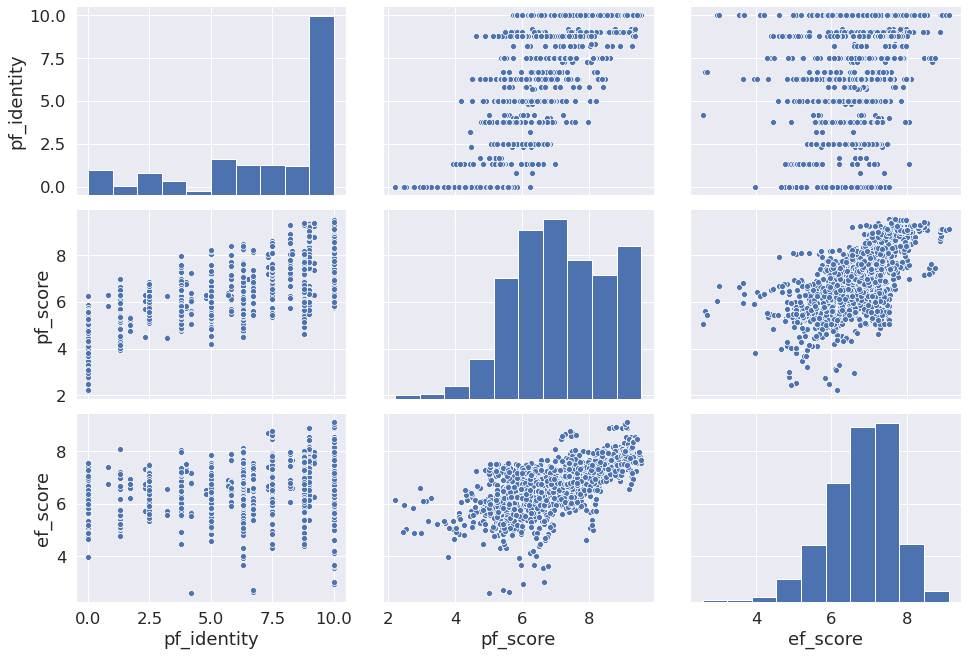

In [34]:
seaborn.pairplot(data=dataset, vars = ["pf_identity", "pf_score", "ef_score"], height=3, aspect=1.5)

* Observando el pairplot notamos que, contrario a lo que esperábamos, las variables pf_score y pf_identity no parecieran ser las más correlacionadas. Éstas serían pf_score y ef_score que tienen una correlación positiva. Sin embargo, considerando que pf_score contiene a pf_identity y observando que los gráficos en los que participa pf_identity no son tan claros es que creemos que el pairplot no es la mejor forma para ver la correlación de esa variable. Al intentar analizar el porqué de esta conclusión es que pensamos que podría deberse al hecho de que la variable pf_identity es, en la práctica, discreta.

#### 4.2

 Los siguientes gráficos son para ver la correlación de pf_identity con ef_score y pf_score. Y podemos observar la correlación positiva entre las variables pf_identity y pf_score, lo cual no se visualizaba mediante el gráfico pairplot.

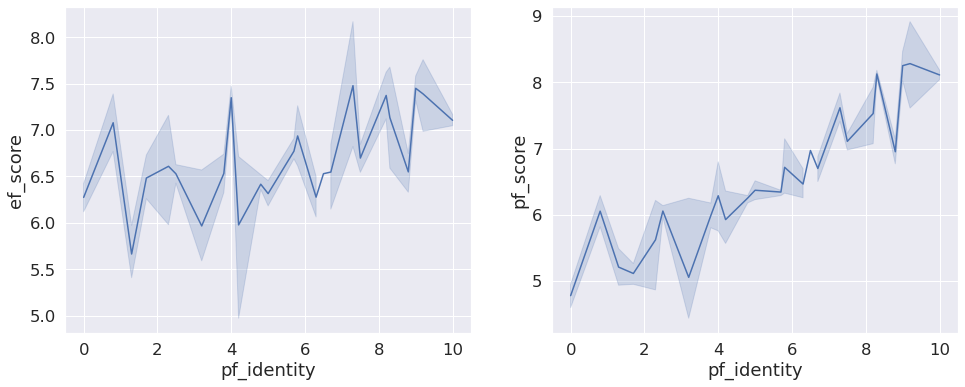

In [35]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 6))

seaborn.lineplot(data= dataset, x='pf_identity', y= 'ef_score',ax=axs[0])
seaborn.lineplot(data= dataset, x='pf_identity', y= 'pf_score', ax=axs[1])

#### 4.3

Dado que teníamos tres categorías: low, medium y high decidimos usar terciles. En la única variable que tuvimos inconvenientes fue en pf_identity porque está muy concentrada en el 10 por lo que tuvimos que sacarle la posibilidad al 10 de caer en el segundo tercil.

In [36]:
pf_identity_1 = dataset['pf_identity'].min()
pf_identity_2 = numpy.quantile(dataset.pf_identity.dropna(),.33)
pf_identity_3 = numpy.quantile(dataset.pf_identity.dropna(),.66)
pf_identity_4 = numpy.quantile(dataset.pf_identity.dropna(),1) 

dataset['pf_identity_segment'] = pandas.cut(dataset.pf_identity, bins=[pf_identity_1 , pf_identity_2, pf_identity_3 - 0.1 , pf_identity_4], labels=['low','medium','high'])

pf_score_1 = dataset['pf_score'].min()
pf_score_2 = numpy.quantile(dataset.pf_score.dropna(),.33)
pf_score_3 = numpy.quantile(dataset.pf_score.dropna(),.66) 
pf_score_4 = numpy.quantile(dataset.pf_score.dropna(),1)

dataset['pf_score_segment'] = pandas.cut(dataset.pf_score, bins=[pf_score_1 ,pf_score_2,pf_score_3,pf_score_4], labels=['low','medium','high'])

ef_score_1 = dataset['ef_score'].min()
ef_score_2 = numpy.quantile(dataset.ef_score.dropna(),.33)
ef_score_3 = numpy.quantile(dataset.ef_score.dropna(),.66) 
ef_score_4 = numpy.quantile(dataset.ef_score.dropna(),1)

dataset['ef_score_segment'] = pandas.cut(dataset.ef_score, bins=[ef_score_1,ef_score_2,ef_score_3,ef_score_4], labels=['low','medium','high'])



In [37]:
dataset.head()

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank,pf_identity_segment,pf_score_segment,ef_score_segment
0,2017,ALB,Albania,Eastern Europe,0.0,10.0,10.0,10.0,7.5,5.8,8.01,46.0,7.67,30.0,7.84,38.0,low,high,high
1,2017,DZA,Algeria,Middle East & North Africa,NaN,0.0,0.0,0.0,0.0,0.0,5.20,146.0,4.77,159.0,4.99,155.0,NaN,low,low
2,2017,AGO,Angola,Sub-Saharan Africa,10.0,0.0,0.0,0.0,5.0,5.0,5.98,121.0,4.83,158.0,5.40,151.0,low,low,low
3,2017,ARG,Argentina,Latin America & the Caribbean,10.0,10.0,10.0,10.0,10.0,10.0,8.04,41.0,5.67,147.0,6.86,77.0,high,high,low
4,2017,ARM,Armenia,Caucasus & Central Asia,7.0,10.0,10.0,10.0,7.5,8.2,7.15,72.0,7.70,27.0,7.42,54.0,medium,medium,high


#### 4.4

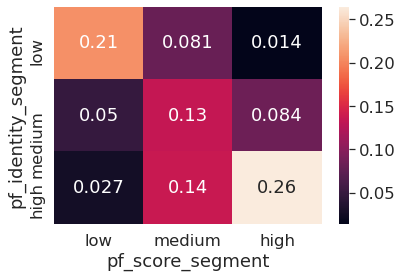

In [38]:
seaborn.heatmap(pandas.crosstab(dataset.pf_identity_segment, dataset.pf_score_segment, normalize=True), annot=True)

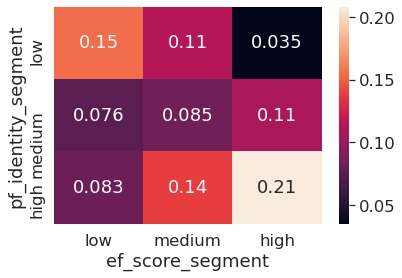

In [39]:
seaborn.heatmap(pandas.crosstab(dataset.pf_identity_segment, dataset.ef_score_segment, normalize=True), annot=True) 

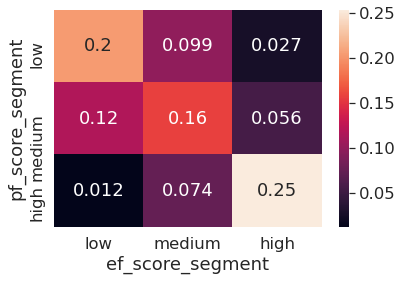

In [40]:
seaborn.heatmap(pandas.crosstab(dataset.pf_score_segment, dataset.ef_score_segment, normalize=True), annot=True)

# Parte 2

Luego del segundo fin de semana de clase, podemos revisitar nuestro trabajo anterior y completarlo respondiendo a las siguientes preguntas:

## 3. Distribuciones

2. Realizar una prueba de Kolmogorov-Smirnof para comprobar analíticamente si estas variables responden la distribución propuesta en el ejercicio anterior. Hint: podés usar https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kstest.html, pero hay que tener en cuenta que si la distribución es "norm", entonces va a comparar los datos con una distribución normal con media 0 y desviación estándar 1. Se puede utilizar la distribución sobre todos los datos o sólo sobre Latinoamérica.

In [41]:
# Selección de países de América Latina
la_filter = dataset['region'] == 'Latin America & the Caribbean'

dataset_la = dataset[la_filter]
df_la_filtered_last_year = df_la_filtered[df_la_filtered['year'] == 2017]

df_world_last_year = dataset[dataset['year'] == 2017]

la_last_year       = df_world_last_year[df_world_last_year['region'] == 'Latin America & the Caribbean' ]
cca_last_year      = df_world_last_year[df_world_last_year['region'] == 'Caucasus & Central Asia' ]

In [42]:
df_world_last_year = dataset[dataset['year'] == 2017]

regions = ['Latin America & the Caribbean','North America','Sub-Saharan Africa','Oceania',
           'Western Europe','Eastern Europe','Caucasus & Central Asia','South Asia','East Asia']

k_tests = []

x     = df_world_last_year['pf_identity']
mu    = numpy.mean( x )
std   = numpy.std( x )
n     = len( x )
#print ( mu, std, n)
test  = [ (y - mu)/(std*numpy.sqrt(n)) for y in x ]
s, p  = scipy.stats.kstest(test,'norm')
kde    = scipy.stats.gaussian_kde(x)
s1, p1 = scipy.stats.kstest(x,kde)
#print( 'World', s, p )

k_tests.append( {
    'region':'World',
    's':s,
    'p-v':p,
    's1':s1,
    'p-v1':p1,
    'Media':mu,
    'Desv. estándar':std,
    'N':n
} )

for reg in regions:
    w     = df_world_last_year[df_world_last_year['region'] == reg]
    x     = w['pf_identity']
    mu    = numpy.mean( x )
    std   = numpy.std( x )
    n     = len( x )
#    print ( mu, std, n)
    test  = [ (y - mu)/(std*numpy.sqrt(n)) for y in x ]
    s, p  = scipy.stats.kstest(test,'norm')
    kde    = scipy.stats.gaussian_kde(x)
    s1, p1 = scipy.stats.kstest(x,kde)
    #print( reg, s, p )

    k_tests.append( {
        'region':reg,
        's':s,
        'p-v':p,
        's1':s1,
        'p-v1':p1,
        'Media':mu,
        'Desv. estándar':std,
        'N':n
    } )
    
    #k_tests.append(( reg,s,pv,mu,std,n))
k_tests = pandas.DataFrame(k_tests)
print("""
    Tests de Kolmogorov-Smirnof para los datos del indicador 'pf_identity', en el mundo y en sus regiones. Las columnas s y p-v muestran el valor del estadístico del test y el p-valor del para los datos normalizados y comparados con una normal de media 0 y desviadión estandar 1. Las columnas s1 y p-v1 muestran el estadístico y el p-valor cuando se realiza el test a los datos con una distribución fiteada con kernels gausianos (gaussian kernel density estimate). Luego la media, la desviasión estandar y la cantidad datos para cada caso.
""")
k_tests


    Tests de Kolmogorov-Smirnof para los datos del indicador 'pf_identity', en el mundo y en sus regiones. Las columnas s y p-v muestran el valor del estadístico del test y el p-valor del para los datos normalizados y comparados con una normal de media 0 y desviadión estandar 1. Las columnas s1 y p-v1 muestran el estadístico y el p-valor cuando se realiza el test a los datos con una distribución fiteada con kernels gausianos (gaussian kernel density estimate). Luego la media, la desviasión estandar y la cantidad datos para cada caso.



,region,s,p-v,s1,p-v1,Media,Desv. estándar,N
0,World,0.465123,1.259253e-32,0.880162,1.359621e-149,6.496914,3.144158,162
1,Latin America & the Caribbean,0.397160,3.275881e-04,0.873589,9.043140e-24,7.400000,1.955859,26
2,North America,0.260250,9.992452e-01,0.589353,3.372626e-01,9.500000,0.500000,2
3,Sub-Saharan Africa,0.397557,1.684285e-06,0.948720,1.314996e-54,5.057143,2.937130,42
4,Oceania,0.327414,7.037758e-01,0.840500,1.294418e-03,8.250000,1.920286,4
5,Western Europe,0.388994,5.795713e-03,0.723287,4.325564e-10,9.311111,0.525874,18
6,Eastern Europe,0.393625,1.388874e-03,0.795803,1.938326e-15,8.836364,0.884999,22
7,Caucasus & Central Asia,0.279936,6.612323e-01,0.867805,1.067393e-05,7.916667,1.458786,6
8,South Asia,0.373413,1.230401e-02,0.914442,1.410896e-18,5.488235,2.788608,17
9,East Asia,0.319246,4.801063e-01,0.814354,8.189787e-05,8.900000,0.608276,6


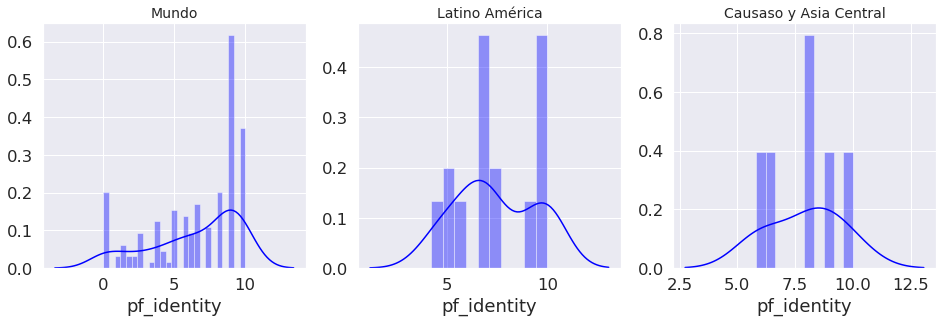

In [43]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4.5))

seaborn.distplot(df_world_last_year['pf_identity'], kde=True, bins=25, label='Mundo', color='blue', norm_hist=True, ax=axs[0])
seaborn.distplot(la_last_year['pf_identity'], kde=True, bins=10, label='Latino América', color='blue', norm_hist=True, ax=axs[1])
seaborn.distplot(cca_last_year['pf_identity'], kde=True, bins=10, label='Causaso y Asia Central', color='blue', norm_hist=True, ax=axs[2])

axs[0].title.set_text("Mundo")
axs[0].title.set_fontsize(14)
axs[1].title.set_text("Latino América")
axs[1].title.set_fontsize(14)
axs[2].title.set_text("Causaso y Asia Central")
axs[2].title.set_fontsize(14)

In [44]:
k_tests_hf_score = []

x     = df_world_last_year['hf_score']
mu    = numpy.mean( x )
std   = numpy.std( x )
n     = len( x )
#print ( mu, std, n)
test  = [ (y - mu)/(std*numpy.sqrt(n)) for y in x ]
s, p  = scipy.stats.kstest(test,'norm')
kde    = scipy.stats.gaussian_kde(x)
s1, p1 = scipy.stats.kstest(x,kde)
#print( 'World', s, p )

k_tests_hf_score.append( {
    'region':'World',
    's':s,
    'p-v':p,
    's1':s1,
    'p-v1':p1,
    'Media':mu,
    'Desv. estándar':std,
    'N':n
} )

for reg in regions:
    w      = df_world_last_year[df_world_last_year['region'] == reg]
    x      = w['hf_score']
    mu     = numpy.mean( x )
    std    = numpy.std( x )
    n      = len( x )
#    print ( mu, std, n)
    test   = [ (y - mu)/(std*numpy.sqrt(n)) for y in x ]
    s, p   = scipy.stats.kstest(test,'norm')
    kde    = scipy.stats.gaussian_kde(x)
    s1, p1 = scipy.stats.kstest(x,kde)
    #print( reg, s, p )

    k_tests_hf_score.append( {
        'region':reg,
        's':s,
        'p-v':p,
        's1':s1,
        'p-v1':p1,
        'Media':mu,
        'Desv. estándar':std,
        'N':n
    } )
    
    #k_tests.append(( reg,s,pv,mu,std,n))
k_tests_hf_score = pandas.DataFrame(k_tests_hf_score)
k_tests = pandas.DataFrame(k_tests)
print("""
    Tests de Kolmogorov-Smirnof para los datos del indicador 'hf_score', en el mundo y en sus regiones. Las columnas s y p-v muestran el valor del estadístico del test y el p-valor del para los datos normalizados y comparados con una normal de media 0 y desviadión estandar 1. Las columnas s1 y p-v1 muestran el estadístico y el p-valor cuando se realiza el test a los datos con una distribución fiteada con kernels gausianos (gaussian kernel density estimate). Luego la media, la desviasión estandar y la cantidad datos para cada caso.
""")
k_tests_hf_score


    Tests de Kolmogorov-Smirnof para los datos del indicador 'hf_score', en el mundo y en sus regiones. Las columnas s y p-v muestran el valor del estadístico del test y el p-valor del para los datos normalizados y comparados con una normal de media 0 y desviadión estandar 1. Las columnas s1 y p-v1 muestran el estadístico y el p-valor cuando se realiza el test a los datos con una distribución fiteada con kernels gausianos (gaussian kernel density estimate). Luego la media, la desviasión estandar y la cantidad datos para cada caso.



,region,s,p-v,s1,p-v1,Media,Desv. estándar,N
0,World,0.443465,1.506728e-29,0.893094,1.095483e-157,6.887963,1.100704,162
1,Latin America & the Caribbean,0.412905,1.587644e-04,0.856874,2.376573e-22,6.951538,0.756707,26
2,North America,0.260250,9.992452e-01,2.161302,0.000000e+00,8.555000,0.095000,2
3,Sub-Saharan Africa,0.385795,3.895011e-06,0.878819,6.634798e-39,6.231429,0.662569,42
4,Oceania,0.289693,8.903455e-01,0.749919,7.822671e-03,7.817500,0.958446,4
5,Western Europe,0.374014,9.062324e-03,1.723394,0.000000e+00,8.412778,0.195528,18
6,Eastern Europe,0.382676,2.085147e-03,0.670544,2.741165e-10,7.605000,0.610758,22
7,Caucasus & Central Asia,0.291554,6.039910e-01,0.684889,2.550394e-03,6.838333,0.670682,6
8,South Asia,0.342601,2.764355e-02,0.932758,2.349419e-20,6.467647,0.614841,17
9,East Asia,0.334029,4.232461e-01,0.657027,4.598565e-03,7.911667,0.855247,6


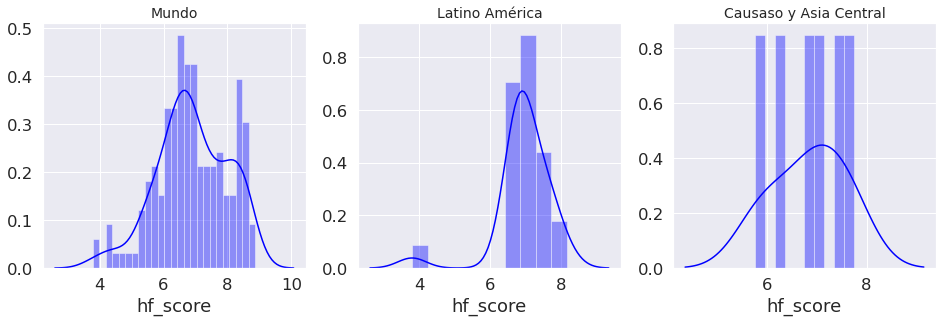

In [45]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4.5))

seaborn.distplot(df_world_last_year['hf_score'], kde=True, bins=25, label='Mundo', color='blue', norm_hist=True, ax=axs[0])
seaborn.distplot(la_last_year['hf_score'], kde=True, bins=10, label='Latino América', color='blue', norm_hist=True, ax=axs[1])
seaborn.distplot(cca_last_year['hf_score'], kde=True, bins=10, label='Causaso y Asia Central', color='blue', norm_hist=True, ax=axs[2])

axs[0].title.set_text("Mundo")
axs[0].title.set_fontsize(14)
axs[1].title.set_text("Latino América")
axs[1].title.set_fontsize(14)
axs[2].title.set_text("Causaso y Asia Central")
axs[2].title.set_fontsize(14)

In [46]:
k_tests = []

df_world = dataset[dataset['year'] == 2017]

for col in df_world.columns:
    if col not in ['year', 'ISO_code', 'countries', 'region','pf_identity_segment','pf_score_segment',
                   'ef_score_segment','pf_identity_legal','pf_identity_divorce','pf_rank','ef_rank','hf_rank']:
        x     = df_world[col]
        mu    = numpy.mean( x )
        std   = numpy.std( x )
        n     = len( x )
        test  = [ (y - mu)/(std*numpy.sqrt(n)) for y in x ]
        s, p  = scipy.stats.kstest(test,'norm')
        s1, p1 = scipy.stats.kstest(df_world[col],scipy.stats.gaussian_kde(df_world[col]))
        #print (col, mu, std, n, s, p)
        k_tests.append( {
            'category':col,
            's':s,
            'p-v':p,
            's1':s1,
            'p-v1':p1,
            'Media':mu,
            'Desv. estándar':std,
            'N':n
        } )
        
k_tests = pandas.DataFrame(k_tests)
print("""
    Tests de Kolmogorov-Smirnof para las datos de todo el mundo de los diferentes indicadores. Las columnas s y p-v muestran el valor del estadístico del test y el p-valor del para los datos normalizados y comparados con una normal de media 0 y desviadión estandar 1. Las columnas s1 y p-v1 muestran el estadístico y el p-valor cuando se realiza el test a los datos con una distribución fiteada con kernels gausianos (gaussian kernel density estimate). Luego la media, la desviasión estandar y la cantidad datos para cada caso.
""")
k_tests


    Tests de Kolmogorov-Smirnof para las datos de todo el mundo de los diferentes indicadores. Las columnas s y p-v muestran el valor del estadístico del test y el p-valor del para los datos normalizados y comparados con una normal de media 0 y desviadión estandar 1. Las columnas s1 y p-v1 muestran el estadístico y el p-valor cuando se realiza el test a los datos con una distribución fiteada con kernels gausianos (gaussian kernel density estimate). Luego la media, la desviasión estandar y la cantidad datos para cada caso.



,category,s,p-v,s1,p-v1,Media,Desv. estándar,N
0,pf_identity_sex_male,0.477617,1.740628e-34,0.845648,2.140600e-131,6.635802,4.708485,162
1,pf_identity_sex_female,0.483325,2.345720e-35,0.792193,3.466326e-109,7.808642,4.117913,162
2,pf_identity_sex,0.478878,1.120822e-34,0.823507,1.602678e-121,7.222222,4.120110,162
3,pf_identity,0.465123,1.259253e-32,0.880162,1.359621e-149,6.496914,3.144158,162
4,pf_score,0.446683,5.397538e-30,0.895361,3.348719e-159,6.976852,1.449555,162
5,ef_score,0.430577,8.404260e-28,0.977150,2.766099e-266,6.799074,0.930856,162
6,hf_score,0.443465,1.506728e-29,0.893094,1.095483e-157,6.887963,1.100704,162


En todos los casos se muestra que el p valor de los test es muy chico (en la mayoría de los casos $<10^{-4}$), entonces lo que podemos concluir es que los datos que hemos probado no siguen una distribución normal o una ajustada con kernels gausianos (scipy.stats.gausssian_kde), las distribuciones probadas. Los p valores más altos encontrados fueron en algunos casos con pocos datos, como los indicadores 'pf_identity' y 'hf_score' en el Caucaso y Asia central, región con sólo 6 países.

In [47]:
x = numpy.random.normal(0,1,10)
y = numpy.random.normal(0,1,100)
z = numpy.random.normal(0,1,1000)
k = numpy.random.normal(0,1,10000)
sx, px   = scipy.stats.kstest(x,'norm')
sy, py   = scipy.stats.kstest(y,'norm')
sz, pz   = scipy.stats.kstest(z,'norm')
sk, pk   = scipy.stats.kstest(k,'norm')
tests = []
tests.append( { 'N': 10, 's': sx, 'p-v': px } )
tests.append( { 'N': 100, 's': sy, 'p-v': py } )
tests.append( { 'N': 1000, 's': sz, 'p-v': pz } )
tests.append( { 'N': 10000, 's': sk, 'p-v': pk } )
tests = pandas.DataFrame(tests)
print("""
    Para mostrar utilidad del test de Kolmogorov-Smirnof, en lo que sigue se muestran los resultados de analizar distribuciones normales generadas con numeros aleatorios de la computadora de diferentes tamaños (10, 100, 1000, 10000). Para distintas pruebas se observa que el p-valor es superior a 0.1 pero aún para N=1000 flutúa bastante de muestra a muestra. En todos los casos el estadístico de test da valores pequeños, que muestra que los datos difieren muy poco de la distribución con la que los esta comparando, este caso normal de media 0 y desviación 1.
""")
tests


    Para mostrar utilidad del test de Kolmogorov-Smirnof, en lo que sigue se muestran los resultados de analizar distribuciones normales generadas con numeros aleatorios de la computadora de diferentes tamaños (10, 100, 1000, 10000). Para distintas pruebas se observa que el p-valor es superior a 0.1 pero aún para N=1000 flutúa bastante de muestra a muestra. En todos los casos el estadístico de test da valores pequeños, que muestra que los datos difieren muy poco de la distribución con la que los esta comparando, este caso normal de media 0 y desviación 1.



,N,s,p-v
0,10,0.222530,0.648033
1,100,0.096239,0.294282
2,1000,0.021841,0.726712
3,10000,0.008344,0.489326


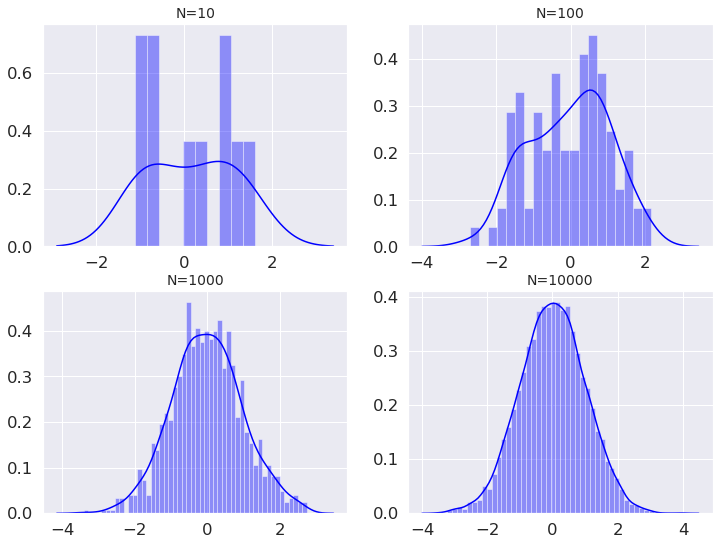

In [48]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 9))

seaborn.distplot(x, kde=True, bins=10, label='N=10', color='blue', norm_hist=True, ax=axs[0,0])
seaborn.distplot(y, kde=True, bins=20, label='N=100', color='blue', norm_hist=True, ax=axs[0,1])
seaborn.distplot(z, kde=True, bins=50, label='N=1000', color='blue', norm_hist=True, ax=axs[1,0])
seaborn.distplot(k, kde=True, bins=50, label='N=10000', color='blue', norm_hist=True, ax=axs[1,1])

axs[0,0].title.set_text("N=10")
axs[0,0].title.set_fontsize(14)
axs[0,1].title.set_text("N=100")
axs[0,1].title.set_fontsize(14)
axs[1,0].title.set_text("N=1000")
axs[1,0].title.set_fontsize(14)
axs[1,1].title.set_text("N=10000")
axs[1,1].title.set_fontsize(14)

## 4. Correlaciones

3. Calcular algún coeficiente de correlación adecuado entre los dos pares de variables, dependiendo de la cantidad de datos, el tipo de datos y la distribución de los mismo. Algunas opciones son: coeficiente de pearson, coeficiente de spearman, coeficientes de tau y de kendall. Interpretar los resultados y justificar si las variables están correlacionadas o no. 
4. [Opcional] Analizar la correlación entre la region y el pf_score (y/o el ef_score); y entre la region y el pf_identity. Considerar que como la variable *region* es ordinal, debe utilizarse algún tipo de test. Explicar cuáles son los requisitos necesarios para la aplicación de ese test. (Si no se cumplieran, se pueden agregar algunos datos para generar más registros). Genere nuevas variables categóricas ordinales para calcular la correlación Tau de Kendal y genere una tabla de contingencia con esas nuevas variables.

Además de completar estos puntos faltantes, luego de haber visitado los conceptos de percepción visual y comunicación efectiva, están en condiciones de reveer los gráficos realizados y evaluar si pueden ser mejorados. Para ello, puede hacerse las siguientes preguntas:

* ¿Están utilizando el tipo de gráfico adecuado para cada tipo de variable?
* Los gráficos, ¿son legibles?
* Los gráficos generados, ¿responden a las preguntas mostrando un patrón claro? En caso de que no, ¿podemos filtrar los datos para que el patrón sea más evidente? ¿o agruparlos de manera distinta? ¿o cambiar el tipo de gráfico?

### 2.4.3 Coeficientes de correlación entre variables



Para ver que correlación aplicar entre las variables, se pueden obtener los gráficos de las distribuciones de las mismas.


Para ello vamos a obtener los datos del último año (2017) de las distintas variables:

In [49]:
df_world_last_year = dataset[dataset['year'] == 2017]

Con este dataFrame podemos proceder a obtener las gráficas de las distribuciones de las variables.

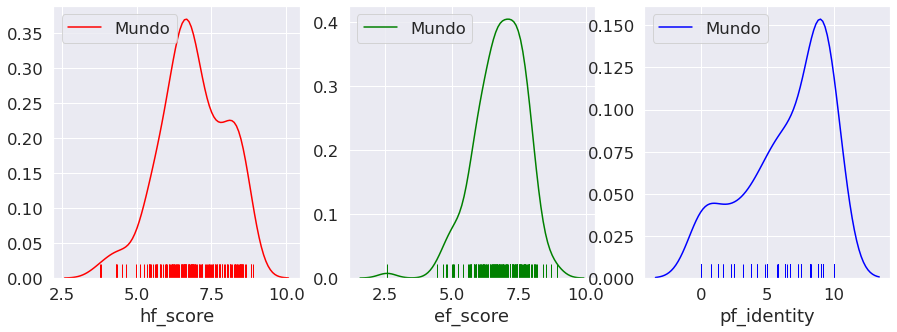

In [51]:
fig, axs = plt.subplots(ncols=3,figsize=(15, 5))
seaborn.distplot(df_world_last_year['hf_score'], hist=False, rug=True, label='Mundo', color='red', ax=axs[0])
seaborn.distplot(df_world_last_year['ef_score'], hist=False, rug=True, label='Mundo', color='green', ax=axs[1])
seaborn.distplot(df_world_last_year['pf_identity'], hist=False, rug=True, label='Mundo', color='blue', ax=axs[2])

Ahora podemos aplicar diferentes métodos de correlación

##### Método de Kendall

In [84]:
columnas = ['pf_identity','pf_score','ef_score']
df_world_last_year[columnas].corr(method='kendall')

,pf_identity,pf_score,ef_score
pf_identity,1.000000,0.580022,0.301084
pf_score,0.580022,1.000000,0.517322
ef_score,0.301084,0.517322,1.000000


#### Método Spearman

In [85]:
df_world_last_year[columnas].corr(method='spearman')

,pf_identity,pf_score,ef_score
pf_identity,1.000000,0.758608,0.422218
pf_score,0.758608,1.000000,0.710746
ef_score,0.422218,0.710746,1.000000


#### Método Pearson

In [86]:
df_world_last_year[columnas].corr(method='pearson')

,pf_identity,pf_score,ef_score
pf_identity,1.000000,0.771508,0.413276
pf_score,0.771508,1.000000,0.695424
ef_score,0.413276,0.695424,1.000000


A partir de estas tablas se puede concluir que hay una correlación alta entre "pf_score" y "ef_score" y entre "pf_identity" y "pf_score" (como era de esperarse).

Por otro lado se observa una baja correlación entre "pf_identity" y "ef_score". 

#### Pregunta extra

La pregunta que surge es si esta correlación se mantiene con el tiempo o fue sola particular para el año 2017. 

Para responder esto podemos ver las correlaciones a medida del transcurso del tiempo.

In [115]:
from scipy import stats
years =[2008,2009,2010,2011,2012,2013,2014,2015,2016,2017]
corr_pfIdentity_pfScore = []
corr_pfIdentity_efScore = []
corr_efScore_pfScore = []
for year in years:
    df_world_year = df_clean[df_clean['year'] == year]
    corr_pfIdentity_pfScore.append(stats.pearsonr(df_world_year['pf_identity'], df_world_year['pf_score'])[0])
    corr_pfIdentity_efScore.append(stats.pearsonr(df_world_year['pf_identity'], df_world_year['ef_score'])[0])
    corr_efScore_pfScore.append(stats.pearsonr(df_world_year['pf_score'], df_world_year['ef_score'])[0])
                                   
corr_list = list(zip(corr_pfIdentity_pfScore,corr_pfIdentity_efScore,corr_efScore_pfScore))
datosCorr = pandas.DataFrame(corr_list, columns=['pfI_pfS', 'pfI_efS','pfS_efS'], index=years)
datosCorr    

,pfI_pfS,pfI_efS,pfS_efS
2008,0.781168,0.391507,0.696493
2009,0.772022,0.391645,0.690791
2010,0.764521,0.366135,0.688541
2011,0.752743,0.390636,0.689933
2012,0.747536,0.409765,0.708612
2013,0.749003,0.395665,0.667106
2014,0.744033,0.370095,0.677349
2015,0.753717,0.383551,0.690028
2016,0.755870,0.386218,0.683679
2017,0.771508,0.413276,0.695424


En forma gráfica:

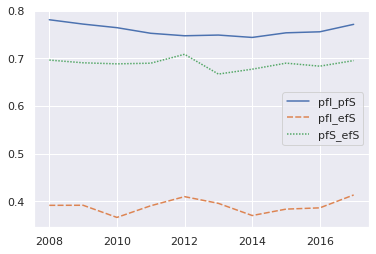

In [118]:
seaborn.lineplot(data=datosCorr)

### 2.4.4 Opcional

Para ver como se correlacionan las variables con las regiones podemos ver primeramente como se distribuyen las mismas. 

Para ello podemos gráficar las distribuciones e identificarlas por región.

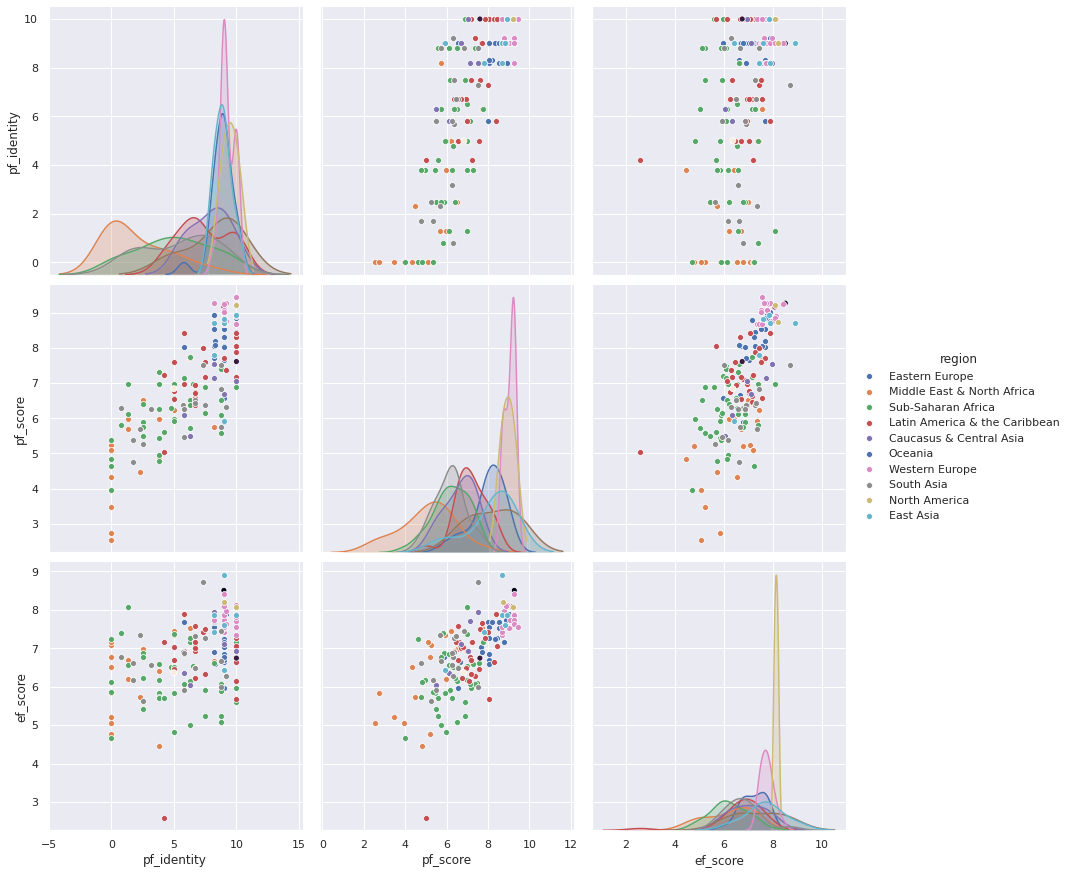

In [87]:
seaborn.pairplot(data=df_world_last_year,vars=['pf_identity','pf_score','ef_score'], hue='region', height= 4)

Mediante la correlación de "kendall" podemos analizar si exite una correlación entre las variables de acuerdo a las regiones. Pero es necesario tener las variables rankeadas para aplicar este método.

Para analizar esta correlación de las variables necesitamos un nuevo dataFrame con los datos de todos lo paises del último año (2017). Para condensar los valores por región utilizamos la media y luego el redondeo para generar variables rankeadas. 

In [75]:
#Obtengo los datos solo del último año:
df_world_last_year = dataset[dataset['year'] == 2017]
#creo una lista con todas la regiones:
regions = ['Oceania','Eastern Europe','Middle East & North Africa','Sub-Saharan Africa','Latin America & the Caribbean','Caucasus & Central Asia','South Asia','Western Europe','North America','East Asia']

#obtengo los promedios de cada una de las variables de interes por región
pf_idetity_mean_by_region = []
ef_score_mean_by_region = []
pf_score_mean_by_region = []
for region in regions:
    data_of_region = df_world_last_year[df_world_last_year['region'] == region]
    pf_idetity_mean_by_region.append(data_of_region['pf_identity'].mean().round())
    ef_score_mean_by_region.append(data_of_region['ef_score'].mean().round())
    pf_score_mean_by_region.append(data_of_region['pf_score'].mean().round())

#Creo una lista con las variables
zipDatos = list(zip(regions, pf_idetity_mean_by_region, ef_score_mean_by_region,pf_score_mean_by_region))
#Creo una dataFrame con los nuevos valores
#datos = pandas.DataFrame(zipDatos, columns=['region','pf_identity', 'ef_score','pf_score'], index=regions)
datos = pandas.DataFrame(zipDatos, columns=['region','pf_identity', 'ef_score','pf_score'])
datos

,region,pf_identity,ef_score,pf_score
0,Oceania,8.0,7.0,8.0
1,Eastern Europe,9.0,7.0,8.0
2,Middle East & North Africa,2.0,6.0,5.0
3,Sub-Saharan Africa,5.0,6.0,6.0
4,Latin America & the Caribbean,7.0,7.0,7.0
5,Caucasus & Central Asia,8.0,7.0,7.0
6,South Asia,5.0,7.0,6.0
7,Western Europe,9.0,8.0,9.0
8,North America,10.0,8.0,9.0
9,East Asia,9.0,8.0,8.0


Con esta nueva tabla podemos gráficar la distribución de las variables:

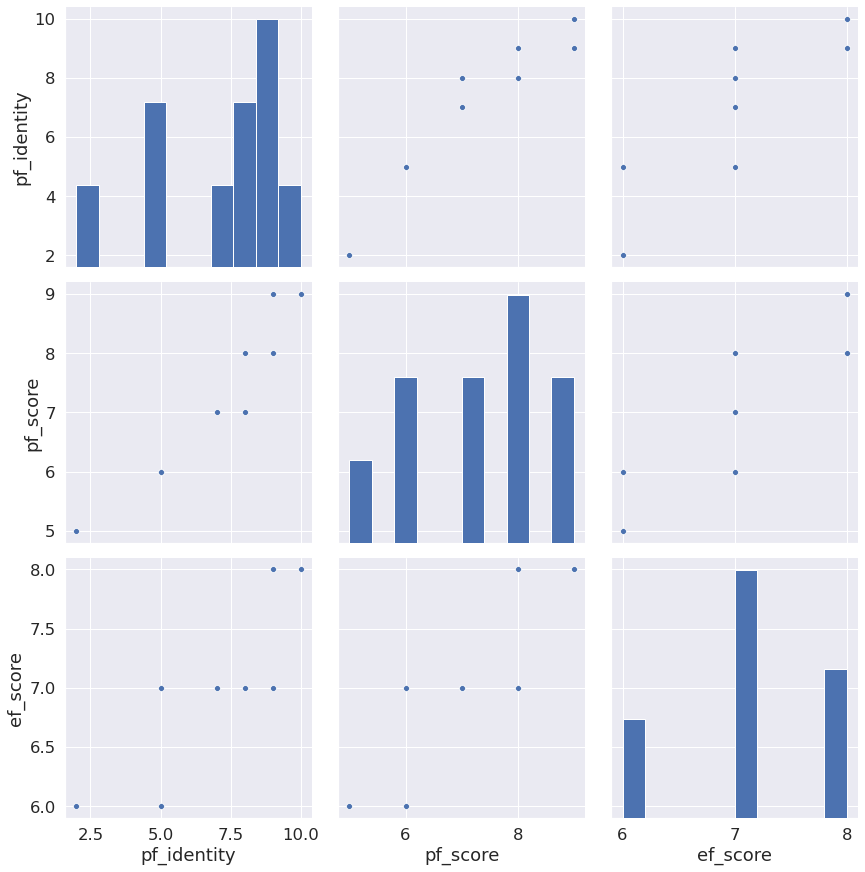

In [76]:
seaborn.pairplot(data=datos,vars=['pf_identity','pf_score','ef_score'], height= 4)

#### Aplicando la correlación de Kendall a los datos

In [77]:
from scipy import stats
stats.kendalltau(datos['pf_identity'], datos['ef_score'])


KendalltauResult(correlation=0.7951465679458908, pvalue=0.005025695647885865)

 Como podemos ver, exite una correlación fuerte (cerca de 0.8) entre las variables de "pf_identity" y "ef_score" por región. Ademas el "pvalue" de bajo valor  nos dice que podemos rechazar la $h_0$ de asociación nula entre los datos. 
 
 La interpretación que se puede hacer es que las variables rankean parecido por región.

In [82]:
stats.kendalltau(datos['pf_identity'], datos['pf_score'])

KendalltauResult(correlation=0.9114654303752998, pvalue=0.0007208380934910343)

In [83]:
stats.pearsonr(datos['pf_identity'], datos['pf_score'])

(0.9492224611513778, 2.7349707624707825e-05)

De igual manera entre "pf_identity" y "pf_score". 

In [80]:
stats.kendalltau(datos['ef_score'], datos['pf_score'])

KendalltauResult(correlation=0.8052762319602711, pvalue=0.0048757063846856675)

In [81]:
stats.spearmanr(datos['pf_identity'], datos['pf_score'])


SpearmanrResult(correlation=0.9495315384465004, pvalue=2.6699951992065992e-05)